<a href="https://colab.research.google.com/github/Vighnesh-Raj/Thesis/blob/main/Options_Hedge_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1 : Load data and summarize

Install Dependencies

Define date range for data extraction

Download SPY & VIX Data from Yfinance

Summary Statistics

#Step 2: Create Volatility Regimes + Allow User input

# Step 3: Scenario Generator ( iid Bootstrap from chosen regime)

#Step 4

Step 1

In [1]:
# STEP 1 : Load data and summarize
import os, sys, math, time, textwrap, json, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

print("✅ Installed & imported: pandas", pd.__version__, "| numpy", np.__version__)

def log_message(msg):
    print(time.strftime("[%Y-%m-%d %H:%M:%S]"), msg)

# Function to get dynamic start and end dates (10 years)
def get_dynamic_date_range(years_back=10):
    today_ny = pd.Timestamp.today(tz="America/New_York").normalize()
    start = today_ny - pd.DateOffset(years=years_back)
    return start.tz_localize(None), today_ny.tz_localize(None)

start_dt, end_dt = get_dynamic_date_range(10)
log_message(f"Dynamic window set: {start_dt.date()} → {end_dt.date()}")

# Rolling Window Length
WINDOW_DAYS = 20

# Robust Close extraction (yfinance sometimes returns MultiIndex)
def _safe_close(df, ticker_col_hint):
    if isinstance(df.columns, pd.MultiIndex):
        # try ('Close', ticker)
        for key in [('Close', ticker_col_hint), ('Adj Close', ticker_col_hint)]:
            if key in df.columns:
                return df[key]
        # fallback: take first level 'Close'
        if 'Close' in df.columns.get_level_values(0):
            return df.xs('Close', axis=1, level=0).iloc[:, 0]
    # single-index case
    for key in ['Close', 'Adj Close']:
        if key in df.columns:
            return df[key]
    raise KeyError("Couldn't find Close column")

def load_market_data_simple(start_dt, end_dt, window_days=WINDOW_DAYS):
    spy = yf.download("SPY", start=start_dt, end=end_dt, progress=False, auto_adjust=True)
    vix = yf.download("^VIX", start=start_dt, end=end_dt, progress=False, auto_adjust=False)
    spy_close = _safe_close(spy, 'SPY').rename("SPY")
    vix_close = _safe_close(vix, '^VIX').rename("VIX")
    df = pd.concat([spy_close, vix_close], axis=1).dropna()
    df["ret_1d"] = df["SPY"].pct_change()
    df["rv_rolling"] = df["ret_1d"].rolling(window_days).std() * np.sqrt(252)
    df = df.dropna()
    return df

df = load_market_data_simple(start_dt, end_dt, window_days=WINDOW_DAYS)

summary = df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T
print("Summary statistics for SPY, VIX, and derived columns:")
display(summary)

# Check ranges
print("Date range:", df.index.min().date(), "->", df.index.max().date())
print("SPY mean:", round(df['SPY'].mean(), 2))
print("VIX mean:", round(df['VIX'].mean(), 2))
print("Avg daily return:", round(df['ret_1d'].mean()*100, 3), "%")
print("Avg 20d annualized vol:", round(df['rv_rolling'].mean()*100, 2), "%")


✅ Installed & imported: pandas 2.2.2 | numpy 2.0.2
[2025-11-06 00:56:19] Dynamic window set: 2015-11-05 → 2025-11-05
Summary statistics for SPY, VIX, and derived columns:


,count,mean,std,min,1%,25%,50%,75%,99%,max
SPY,2494.0,349.115909,132.697860,155.438858,163.467734,239.942387,332.877686,427.076996,663.242920,687.390015
VIX,2494.0,18.510962,7.352601,9.140000,9.648600,13.502500,16.719999,21.527501,45.244902,82.690002
ret_1d,2494.0,0.000610,0.011394,-0.109424,-0.033101,-0.003634,0.000712,0.005961,0.026430,0.105019
rv_rolling,2494.0,0.149956,0.103125,0.031905,0.047146,0.088293,0.121843,0.186807,0.577735,0.931852


Date range: 2015-12-04 -> 2025-11-04
SPY mean: 349.12
VIX mean: 18.51
Avg daily return: 0.061 %
Avg 20d annualized vol: 15.0 %


Step2: Volatility Regime

In [2]:
# STEP 2: Create Volatility Regimes + Allow User input

def compute_regime_thresholds(df, q_low=0.33, q_high=0.66):
    vix = df["VIX"].dropna().astype(float)
    lo = float(vix.quantile(q_low)); hi = float(vix.quantile(q_high))
    if lo >= hi:
        med = float(vix.median()); lo, hi = med, med + 0.01
    if not np.isfinite(lo) or not np.isfinite(hi):
        med = float(vix.median()); lo, hi = med, med
    return lo, hi

def add_regime_labels(df, lo, hi):
    def lab(v):
        if v <= lo: return "LOW"
        elif v >= hi: return "HIGH"
        else: return "MID"
    out = df.copy()
    out["regime"] = out["VIX"].astype(float).apply(lab)
    return out

lo, hi = compute_regime_thresholds(df, q_low=0.33, q_high=0.66)
df_reg = add_regime_labels(df, lo, hi)

print(f"VIX Regime Thresholds: LOW <= {lo:.2f}, MID ({lo:.2f} < VIX < {hi:.2f}), HIGH >= {hi:.2f}")
print(df_reg["regime"].value_counts().to_frame("days"))
print("Suggested regime *today*:", df_reg["regime"].iloc[-1])

def suggested_regime_today(df_reg): return str(df_reg["regime"].iloc[-1])

def select_regime_pool(df_reg, mode="auto", override=None):
    valid = {"LOW","MID","HIGH"}
    if mode == "auto":
        chosen = suggested_regime_today(df_reg)
    else:
        if override is None or str(override).upper() not in valid:
            raise ValueError("When mode!='auto', override must be one of: LOW, MID, HIGH.")
        chosen = str(override).upper()
    pool = df_reg[df_reg["regime"] == chosen].copy()
    if pool.empty:
        raise ValueError(f"No rows found for regime '{chosen}'. Check thresholds or data.")
    return chosen, pool

chosen, pool = select_regime_pool(df_reg, mode="auto")
print(f"Using regime: {chosen} | pool size: {len(pool)} rows")


VIX Regime Thresholds: LOW <= 14.57, MID (14.57 < VIX < 19.40), HIGH >= 19.40
        days
regime      
HIGH     851
LOW      824
MID      819
Suggested regime *today*: MID
Using regime: MID | pool size: 819 rows


Step3: Scenario Generator

In [3]:
# STEP 3: Scenario Generator

def simulate_terminal_from_pool(df_reg, pool, days=5, n_scen=2000, seed=42, vix_floor=8.0):
    rng = np.random.default_rng(seed)
    S0 = float(df_reg["SPY"].iloc[-1])
    V0 = float(df_reg["VIX"].iloc[-1])
    ret_pool = pool["ret_1d"].dropna().values
    dvix_pool = pool["VIX"].pct_change().dropna().values
    if len(ret_pool) < 50 or len(dvix_pool) < 50:
        raise ValueError("Regime pool too small after cleaning; adjust thresholds or use AUTO.")
    S_T = np.empty(n_scen, dtype=float)
    V_T = np.empty(n_scen, dtype=float)
    for k in range(n_scen):
        r  = rng.choice(ret_pool,  size=days, replace=True)
        dv = rng.choice(dvix_pool, size=days, replace=True)
        S_T[k] = S0 * np.prod(1.0 + r)
        V_T[k] = max(vix_floor, V0 * np.prod(1.0 + dv))
    return S_T, V_T

def simulate_terminal(df_reg, pool, horizon="1w", n_scen=2000, seed=42):
    horizon = str(horizon).lower()
    map_days = {"1w": 5, "1m": 21, "3m": 63, "1y": 252}
    if horizon not in map_days:
        raise ValueError(f"horizon must be one of {list(map_days.keys())}")
    days = map_days[horizon]
    if days <= 5:
        return simulate_terminal_from_pool(df_reg, pool, days=days, n_scen=n_scen, seed=seed)
    else:
        rng = np.random.default_rng(seed)
        S0 = float(df_reg["SPY"].iloc[-1])
        V0 = float(df_reg["VIX"].iloc[-1])
        ret_pool = pool["ret_1d"].dropna().values
        dvix_pool = pool["VIX"].pct_change().dropna().values
        if len(ret_pool) < 50:
            raise ValueError("Regime pool too small.")
        block = 5
        n_blocks = max(1, days // block)
        S_T, V_T = np.empty(n_scen), np.empty(n_scen)
        for k in range(n_scen):
            r_seq, dv_seq = [], []
            for _ in range(n_blocks):
                r_seq.extend(rng.choice(ret_pool, size=block, replace=True))
                dv_seq.extend(rng.choice(dvix_pool, size=block, replace=True))
            S_T[k] = S0 * np.prod(1.0 + np.array(r_seq)[:days])
            V_T[k] = max(8.0, V0 * np.prod(1.0 + np.array(dv_seq)[:days]))
        return S_T, V_T

# quick tests
for h in ["1w", "1m", "3m", "1y"]:
    S_T, V_T = simulate_terminal(df_reg, pool, horizon=h, n_scen=1000, seed=123)
    print(f"{h}: median SPY={np.median(S_T):.2f}, median VIX={np.median(V_T):.2f}")


1w: median SPY=680.81, median VIX=19.04
1m: median SPY=694.77, median VIX=19.13
3m: median SPY=739.11, median VIX=19.00
1y: median SPY=971.00, median VIX=20.65


Step3.5: Quotes

In [4]:
# STEP 3.5 (REPLACE THIS CELL): Quotes input (BID/ASK REQUIRED; mid is derived)
def validate_quotes_df_bidask_strict(quotes: pd.DataFrame) -> pd.DataFrame:
    """
    Requires: kind, strike, bid, ask, expiry
    Optional: label
    - kind in {'C','P'} (case-insensitive)
    - strike > 0, bid >= 0, ask > 0, ask >= bid
    - all rows share the same expiry (for now)
    - adds 'mid' = (bid+ask)/2 for convenience
    - sorts by kind, strike
    """
    req = {"kind","strike","bid","ask","expiry"}
    cols_lower = {c.lower() for c in quotes.columns}
    missing = req - cols_lower
    if missing:
        raise ValueError(f"quotes must include: {sorted(req)}; missing {sorted(missing)}")

    q = quotes.copy()
    q.columns = [c.lower() for c in q.columns]

    # normalize / types
    q["kind"]   = q["kind"].str.upper().str.strip()
    q["strike"] = pd.to_numeric(q["strike"], errors="coerce")
    q["bid"]    = pd.to_numeric(q["bid"], errors="coerce")
    q["ask"]    = pd.to_numeric(q["ask"], errors="coerce")
    q["expiry"] = q["expiry"].astype(str).str.strip()

    # checks
    if not q["kind"].isin(["C","P"]).all():
        bad = q.loc[~q["kind"].isin(["C","P"]), "kind"].unique().tolist()
        raise ValueError(f"kind must be 'C' or 'P'; got {bad}")
    if (q["strike"]<=0).any():
        raise ValueError("strike must be positive")
    if (q["ask"]<=0).any() or (q["bid"]<0).any():
        raise ValueError("ask must be >0 and bid must be >=0")
    if (q["ask"] < q["bid"]).any():
        bad = q[q["ask"] < q["bid"]][["kind","strike","bid","ask"]]
        raise ValueError(f"ask < bid for rows:\n{bad}")
    exps = q["expiry"].unique()
    if len(exps) != 1:
        raise ValueError(f"single expiry required for now; got: {exps}")

    # add label if missing
    if "label" not in q.columns:
        q["label"] = q["kind"] + q["strike"].map(lambda x: f"{x:g}")

    # compute mid internally (so downstream code can keep using 'mid' as convenience)
    q["mid"] = 0.5*(q["bid"] + q["ask"])

    # order nicely
    q = q.sort_values(["kind","strike"]).reset_index(drop=True)
    return q

# --- EXAMPLE (bid/ask only; no 'mid' column needed) ---
quotes_demo = pd.DataFrame({
    "kind":   ["C","C","P","P"],
    "strike": [673, 665, 677, 670],
    "bid":    [5.72,  11.39, 7.45, 4.51 ],
    "ask":    [5.76,  11.44,  7.49,4.53],
    "expiry": ["2025-10-31"]*4,
    "label":  ["C673","C665","P677","P670"],
})

q = validate_quotes_df_bidask_strict(quotes_demo)
q  # (optional) peek


,kind,strike,bid,ask,expiry,label,mid
0,C,665,11.39,11.44,2025-10-31,C665,11.415
1,C,673,5.72,5.76,2025-10-31,C673,5.740
2,P,670,4.51,4.53,2025-10-31,P670,4.520
3,P,677,7.45,7.49,2025-10-31,P677,7.470


Step4: Optmizer Function

In [5]:
# STEP 4: optimize_hedge() — budgeted CVaR hedge (retail-first)
from typing import Optional
from scipy.optimize import linprog
import math

def optimize_hedge(
    quotes_df: pd.DataFrame,
    df_reg: pd.DataFrame,
    pool: pd.DataFrame,
    *,
    horizon: str = "1w",
    n_scen: int = 2000,
    seed: int = 123,
    alpha: float = 0.95,
    n_shares: int = 20,
    risk_free: float = 0.00,
    zero_cost: bool = False,
    budget_usd: float = 200.0,
    allow_net_credit: bool = False,
    allow_buy_calls: bool = True,
    allow_sell_calls: bool = False,
    allow_buy_puts:  bool = True,
    allow_sell_puts: bool = False,
    max_buy_contracts: float = 10.0,
    max_sell_contracts: float = 10.0,
    round_step: Optional[float] = None
):
    # --- helpers inside ---
    def _validate_quotes(q: pd.DataFrame) -> pd.DataFrame:
        req = {"kind","strike","mid","expiry"}
        if req - set(q.columns.str.lower()):
            raise ValueError("quotes_df must include: kind, strike, mid, expiry")
        qq = q.copy(); qq.columns = [c.lower() for c in qq.columns]
        qq["kind"]   = qq["kind"].str.upper().str.strip()
        qq["strike"] = pd.to_numeric(qq["strike"], errors="coerce")
        qq["mid"]    = pd.to_numeric(qq["mid"], errors="coerce")
        qq["expiry"] = qq["expiry"].astype(str)
        if not qq["kind"].isin(["C","P"]).all(): raise ValueError("kind must be C or P")
        if (qq["mid"]<=0).any(): raise ValueError("mid must be positive")
        if len(qq["expiry"].unique())!=1: raise ValueError("one expiry only for now")
        for col in ["bid","ask"]:
            if col in qq.columns: qq[col] = pd.to_numeric(qq[col], errors="coerce")
        if "label" not in qq.columns:
            qq["label"] = qq["kind"] + qq["strike"].map(lambda x:f"{x:g}")
        return qq.sort_values(["kind","strike"]).reset_index(drop=True)

    def _norm_cdf(x): return 0.5*(1.0 + math.erf(x/math.sqrt(2.0)))
    def _bs_price(S, K, tau, r, sigma, kind):
        tau = max(tau, 1e-8); sigma = max(sigma, 1e-8)
        d1  = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        d2  = d1 - sigma*np.sqrt(tau)
        Nd1 = _norm_cdf(d1); Nd2 = _norm_cdf(d2)
        if kind=="C": return S*Nd1 - K*np.exp(-r*tau)*Nd2
        else:         return K*np.exp(-r*tau)*(1.0-Nd2) - S*(1.0-Nd1)
    def _iv_from_vix(VT, floor=0.08, cap=1.00): return np.clip(VT/100.0, floor, cap)
    def _days_to_expiry(expiry_str, today_ts): return max(int((pd.Timestamp(expiry_str)-today_ts).days), 0)

    def _build_mats(q, ST, VT, today_ts, horizon_days, r=0.0, mult=100.0):
        N, m = len(ST), len(q)
        X_buy  = np.empty((N,m)); X_sell = np.empty((N,m))
        c_buy  = np.empty(m);     c_sell = np.empty(m)
        for j, rr in q.iterrows():
            kind = rr["kind"]; K=float(rr["strike"]); mid0=float(rr["mid"])
            bid0 = float(rr.get("bid", np.nan)); ask0 = float(rr.get("ask", np.nan))
            if not np.isfinite(bid0) or not np.isfinite(ask0):
                spr = 0.02*mid0
                bid0 = max(mid0 - spr, mid0*0.5)
                ask0 = max(mid0 + spr, bid0 + 1e-6)
            tauT  = max((_days_to_expiry(rr["expiry"], today_ts) - horizon_days)/252.0, 1e-6)
            sigT  = _iv_from_vix(VT)
            priceT = np.vectorize(_bs_price, otypes=[float])(ST, K, tauT, r, sigT, kind)
            X_buy[:, j]  = (priceT - ask0)*mult
            X_sell[:, j] = (bid0 - priceT)*mult
            c_buy[j]  = ask0*mult
            c_sell[j] = -bid0*mult
        return X_buy, X_sell, c_buy, c_sell

    def _var_cvar(pnl, a=0.95):
        loss = -np.asarray(pnl)
        var  = float(np.quantile(loss, a))
        tail = loss[loss >= var]
        cvar = float(np.mean(tail)) if tail.size else var
        return var, cvar

    # simulate terminal
    days_map = {"1w":5, "1m":21, "3m":63, "1y":252}
    if horizon not in days_map: raise ValueError("horizon must be one of '1w','1m','3m','1y'")
    h_days   = days_map[horizon]
    ST, VT   = simulate_terminal(df_reg, pool, horizon=horizon, n_scen=n_scen, seed=seed)
    S0       = float(df_reg["SPY"].iloc[-1])
    today_ts = df_reg.index[-1]
    y_scaled = (ST - S0) * float(n_shares)

    # quotes & design matrices
    q = _validate_quotes(quotes_df)
    Xp, Xm, c_plus, c_minus = _build_mats(q, ST, VT, today_ts, h_days, r=risk_free)

    # CVaR LP (Rockafellar–Uryasev)
    N, m = Xp.shape
    nvar = 2*m + 1 + N
    idx_wp = slice(0, m); idx_wm = slice(m, 2*m); idx_z = 2*m; idx_u = slice(2*m+1, 2*m+1+N)

    c_vec = np.zeros(nvar); c_vec[idx_z] = 1.0; c_vec[idx_u] = 1.0/((1.0 - alpha)*N)
    A_ub, b_ub = [], []

    # tail constraints
    for i in range(N):
        row = np.zeros(nvar)
        row[idx_wp] = -Xp[i]; row[idx_wm] = -Xm[i]; row[idx_z] = -1.0; row[2*m+1+i] = -1.0
        A_ub.append(row); b_ub.append(y_scaled[i])
    # u >= 0
    for i in range(N):
        row = np.zeros(nvar); row[2*m+1+i] = -1.0
        A_ub.append(row); b_ub.append(0.0)

    # budget
    row_cost = np.zeros(nvar); row_cost[idx_wp] = c_plus; row_cost[idx_wm] = c_minus
    if zero_cost:
        A_ub.append(row_cost.copy());   b_ub.append(0.0)
        A_ub.append((-row_cost).copy()); b_ub.append(0.0)
    else:
        B = float(budget_usd)
        if allow_net_credit:
            A_ub.append(row_cost.copy());    b_ub.append(B)
            A_ub.append((-row_cost).copy()); b_ub.append(B)
        else:
            A_ub.append(row_cost.copy());    b_ub.append(B)   # cost ≤ B
            A_ub.append((-row_cost).copy()); b_ub.append(0.0) # cost ≥ 0

    A_ub = np.vstack(A_ub); b_ub = np.asarray(b_ub)

    # bounds
    bounds = []
    kinds = q["kind"].tolist()
    for k in kinds:  # buys
        if (k=="C" and not allow_buy_calls) or (k=="P" and not allow_buy_puts):
            bounds.append((0.0, 0.0))
        else:
            bounds.append((0.0, max_buy_contracts))
    for k in kinds:  # sells
        if (k=="C" and not allow_sell_calls) or (k=="P" and not allow_sell_puts):
            bounds.append((0.0, 0.0))
        else:
            bounds.append((0.0, max_sell_contracts))
    bounds.append((None, None))            # z free
    bounds.extend([(0.0, None)]*N)         # u_i >= 0

    res = linprog(c_vec, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
    if not res.success: raise RuntimeError(f"CVaR LP failed: {res.message}")

    x  = res.x
    wp = x[idx_wp]; wm = x[idx_wm]
    pnl_unhedged = y_scaled
    pnl_hedged   = y_scaled + (Xp @ wp) + (Xm @ wm)

    if round_step is not None and round_step > 0:
        wp = np.round(wp/round_step)*round_step
        wm = np.round(wm/round_step)*round_step
        pnl_hedged = y_scaled + (Xp @ wp) + (Xm @ wm)

    spend = float(c_plus @ wp + c_minus @ wm)
    var_emp, cvar_emp = _var_cvar(pnl_hedged, a=alpha)

    return {
        "weights": {"buy": wp.copy(), "sell": wm.copy(), "net": (wp-wm).copy(), "labels": q["label"].tolist()},
        "spend_usd": spend,
        "pnl": {"unhedged": pnl_unhedged, "hedged": pnl_hedged},
        "risk": {"alpha": alpha, "var": var_emp, "cvar": cvar_emp},
        "meta": {"horizon": horizon, "n_scen": int(n_scen), "n_shares": int(n_shares),
                 "zero_cost": bool(zero_cost), "allow_net_credit": bool(allow_net_credit)}
    }

# ---- Example call (retail-like: buy-only, spend up to $200 on 20 shares) ----
result = optimize_hedge(
    quotes_df=q, df_reg=df_reg, pool=pool,
    horizon="1w", n_scen=2000, seed=123, alpha=0.95,
    n_shares=215, risk_free=0.00,
    zero_cost=False, budget_usd=200000.0, allow_net_credit=True,
    allow_buy_calls=True, allow_buy_puts=True,
    allow_sell_calls=True, allow_sell_puts=True,
    max_buy_contracts=10.0, max_sell_contracts=10.0,
    round_step=None
)

print("Spend (USD):", result["spend_usd"])
print(f"VaR@{result['risk']['alpha']:.2f} (loss): {result['risk']['var']:.2f}")
print(f"CVaR@{result['risk']['alpha']:.2f} (loss): {result['risk']['cvar']:.2f}")
print("Net contracts:")
for lbl, w in zip(result["weights"]["labels"], result["weights"]["net"]):
    print(f"  {lbl:>10s}: {w:7.3f}")


Spend (USD): -284.29161494920163
VaR@0.95 (loss): 491.29
CVaR@0.95 (loss): 498.21
Net contracts:
        C665:  -0.367
        C673:  -1.783
        P670:   1.304
        P677:   0.752


In [6]:
# ===========================
# Menu-driven hedge workflow
# ===========================
from dataclasses import dataclass

@dataclass
class Prefs:
    # Scenario/portfolio
    horizon: str = "1w"         # '1w'|'1m'|'3m'|'1y'
    n_scen: int = 2000
    seed: int = 123
    alpha: float = 0.95
    n_shares: int = 20
    risk_free: float = 0.00

    # Permissions (toggles)
    retail_mode: bool = True            # if True, defaults to buy-only
    allow_selling: bool = False         # overridden to True if institutional toggle on
    zero_cost: bool = False             # if True, enforce cost ~= 0 at solve (LP) and rounding stage
    allow_net_credit: bool = False      # only relevant when zero_cost=False
    budget_usd: float = 200.0           # ignored when zero_cost=True

    # Bounds
    max_buy_contracts: float = 10.0
    max_sell_contracts: float = 10.0

    # Rounding & evaluation
    integer_round: bool = True          # round to whole contracts for display/execution
    step: float = 1.0                   # 1.0=whole; 0.1=tenths (for exploration)
    budget_enforced_after_rounding: bool = True
    zero_cost_tolerance: float = 5.0    # dollars tolerance after integer rounding (institutional)
    make_plots: bool = True             # payoff-at-expiry + P&L histogram


# ---------- small helpers re-used ----------
import numpy as np, pandas as pd, math
import matplotlib.pyplot as plt

def _var_cvar_from_pnl(pnl: np.ndarray, alpha: float = 0.95):
    loss = -np.asarray(pnl)
    var  = float(np.quantile(loss, alpha))
    tail = loss[loss >= var]
    cvar = float(tail.mean()) if tail.size else var
    return var, cvar

def _print_table(pnl_unh, pnl_hd, alpha):
    vu, cu = _var_cvar_from_pnl(pnl_unh, alpha)
    vh, ch = _var_cvar_from_pnl(pnl_hd,  alpha)
    print("\n=== VaR/CVaR Comparison (on LOSS; more negative = better) ===")
    print(f"{'':12s} {'VaR@'+str(alpha):>14s} {'CVaR@'+str(alpha):>16s}")
    print(f"{'Unhedged':12s} {vu:14.2f} {cu:16.2f}")
    print(f"{'Hedged':12s}   {vh:14.2f} {ch:16.2f}")
    print(f"{'Improvement Δ':12s} {(vu-vh):14.2f} {(cu-ch):16.2f}")

def _rebuild_eval_mats(quotes_df, df_reg, pool, *, horizon, n_scen, seed, risk_free, n_shares):
    # reuse your simulate_terminal
    ST, VT = simulate_terminal(df_reg, pool, horizon=horizon, n_scen=n_scen, seed=seed)
    S0 = float(df_reg["SPY"].iloc[-1]); today_ts = df_reg.index[-1]
    y_unhedged = (ST - S0) * n_shares

    days_map = {"1w":5, "1m":21, "3m":63, "1y":252}
    h_days = days_map[horizon]

    # repricer consistent with your optimize_hedge
    def _norm_cdf(x): return 0.5*(1.0 + math.erf(x/math.sqrt(2.0)))
    def _bs_price(S, K, tau, r, sigma, kind):
        tau = max(tau, 1e-8); sigma = max(float(sigma), 1e-8)
        d1  = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        d2  = d1 - sigma*np.sqrt(tau)
        Nd1 = _norm_cdf(d1); Nd2 = _norm_cdf(d2)
        if kind == "C": return S*Nd1 - K*np.exp(-r*tau)*Nd2
        else:           return K*np.exp(-r*tau)*(1.0-Nd2) - S*(1.0-Nd1)
    def _iv_from_vix(VT, floor=0.08, cap=1.00): return np.clip(np.asarray(VT)/100.0, floor, cap)
    def _days_to_expiry(expiry_str, today_ts): return max(int((pd.Timestamp(expiry_str)-today_ts).days), 0)

    q = quotes_df.copy(); q.columns = [c.lower() for c in q.columns]
    N, m = len(ST), len(q)
    Xp = np.empty((N,m)); Xm = np.empty((N,m))
    c_plus = np.empty(m);  c_minus = np.empty(m)
    sigT = _iv_from_vix(VT)
    for j, rr in q.iterrows():
        kind = rr["kind"]; K=float(rr["strike"])
        ask0 = float(rr.get("ask", np.nan)); bid0 = float(rr.get("bid", np.nan)); mid0 = float(rr.get("mid", np.nan))
        if not np.isfinite(ask0) or not np.isfinite(bid0):
            if not np.isfinite(mid0) or mid0 <= 0: raise ValueError("Need bid/ask or mid to evaluate.")
            spr = 0.02*mid0; bid0 = max(mid0 - spr, mid0*0.5); ask0 = max(mid0 + spr, bid0 + 1e-6)
        tauT = max((_days_to_expiry(rr["expiry"], today_ts) - h_days)/252.0, 1e-6)
        priceT = np.array([_bs_price(S, K, tauT, risk_free, s, kind) for S, s in zip(ST, sigT)])
        Xp[:, j] = (priceT - ask0) * 100.0
        Xm[:, j] = (bid0   - priceT) * 100.0
        c_plus[j]  = ask0 * 100.0
        c_minus[j] = -bid0 * 100.0
    return ST, VT, y_unhedged, Xp, Xm, c_plus, c_minus

# ---- Rounding strategies ----
def retail_budget_aware_integer_rounding(wp, c_plus, budget_usd, step=1.0):
    wp = np.asarray(wp, float)
    w = np.round(wp/step)*step
    spend = float(c_plus @ w)
    if spend <= budget_usd: return w, spend
    # proportional scale + floor
    if spend > 0:
        scale = budget_usd / spend
        w = np.floor((w*scale)/step)*step
    spend = float(c_plus @ w)
    if spend <= budget_usd: return w, spend
    # greedy trim most expensive legs
    order = np.argsort(-c_plus)
    while spend > budget_usd + 1e-9 and w.sum() > 0:
        for j in order:
            if w[j] >= step:
                w[j] -= step
                spend = float(c_plus @ w)
                if spend <= budget_usd + 1e-9: break
    return w, float(c_plus @ w)

def institutional_zero_cost_integer_rounding(wp, wm, c_plus, c_minus,
                                             max_buy, max_sell, step=1.0, tol=5.0):
    """
    Round both buys and sells to integer step while keeping net cost ~ 0 (±tol).
    Greedy fix-up by tweaking legs with best cost leverage.
    """
    wp = np.asarray(wp, float); wm = np.asarray(wm, float)
    wp_r = np.clip(np.round(wp/step)*step, 0, max_buy)
    wm_r = np.clip(np.round(wm/step)*step, 0, max_sell)
    def cost(wp_, wm_): return float(c_plus @ wp_ + c_minus @ wm_)  # c_minus <= 0
    curr_cost = cost(wp_r, wm_r)
    if abs(curr_cost) <= tol: return wp_r, wm_r, curr_cost

    # candidates to tweak:
    #  - increasing buys raises cost by +c_plus
    #  - increasing sells (wm) lowers cost by +c_minus (negative) => reduces cost
    # We'll move in 1 step increments on the leg with best improvement toward zero.
    for _ in range(10000):  # safety cap
        curr_cost = cost(wp_r, wm_r)
        if abs(curr_cost) <= tol: break
        if curr_cost < -tol:
            # too negative (net credit) -> need to increase cost:
            # try: decrease sells (if wm_r>0) or increase buys (if below cap)
            best_gain, action = -np.inf, None
            # option A: reduce one step of a sell (cost increases by -c_minus[j] >0)
            for j in range(len(wm_r)):
                if wm_r[j] >= step:
                    gain = -c_minus[j]  # removing a sell increases cost by -c_minus
                    if gain > best_gain: best_gain, action = gain, ('dec_sell', j)
            # option B: add one step of a buy (cost increases by c_plus[j] >0)
            for j in range(len(wp_r)):
                if wp_r[j] + step <= max_buy:
                    gain = c_plus[j]
                    if gain > best_gain: best_gain, action = gain, ('inc_buy', j)
            if action is None: break
            kind, j = action
            if kind=='dec_sell': wm_r[j] -= step
            else:                 wp_r[j] += step
        else:
            # too positive (net spend) -> need to decrease cost:
            # try: increase sells (if below cap) or decrease buys (if wp_r>0)
            best_drop, action = -np.inf, None
            # option A: add one step of a sell (cost changes by c_minus[j] < 0)
            for j in range(len(wm_r)):
                if wm_r[j] + step <= max_sell:
                    drop = -c_minus[j]  # magnitude
                    if drop > best_drop: best_drop, action = drop, ('inc_sell', j)
            # option B: remove one step of a buy (cost decreases by c_plus[j])
            for j in range(len(wp_r)):
                if wp_r[j] >= step:
                    drop = c_plus[j]
                    if drop > best_drop: best_drop, action = drop, ('dec_buy', j)
            if action is None: break
            kind, j = action
            if kind=='inc_sell': wm_r[j] += step
            else:                 wp_r[j] -= step

    return wp_r, wm_r, cost(wp_r, wm_r)

# ---- Payoff plot (expiry) and P&L histogram ----
def payoff_chart_at_expiry(quotes_df, labels, wp, wm, n_shares, S0):
    S_grid = np.linspace(0.7*S0, 1.3*S0, 161); mult=100.0
    ask0 = quotes_df['ask'].to_numpy(float); bid0 = quotes_df['bid'].to_numpy(float)
    strikes = quotes_df['strike'].to_numpy(float); kinds = quotes_df['kind'].tolist()
    init_cost = float((ask0*mult) @ wp + (-bid0*mult) @ wm)
    def intrinsic(S,K,kind): return max(S-K,0.0) if kind=='C' else max(K-S,0.0)
    opt_payoff = []
    for S in S_grid:
        v=0.0
        for j,k in enumerate(kinds):
            intr = intrinsic(S, strikes[j], k)*mult
            v += wp[j]*intr - wm[j]*intr   # short = -long
        opt_payoff.append(v)
    shares = n_shares*(S_grid - S0)
    tot = shares + np.array(opt_payoff) - init_cost
    plt.figure(figsize=(7,4.5))
    plt.plot(S_grid, tot, label="Hedged total P&L at expiry")
    plt.axhline(0, ls="--"); plt.axvline(S0, ls=":")
    plt.title("Payoff at Expiry (includes initial premium)"); plt.xlabel("SPY at Expiry"); plt.ylabel("P&L (USD)")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_pnl_hist(pnl_unhedged, pnl_hedged):
    plt.figure(figsize=(7,4.5))
    plt.hist(pnl_unhedged, bins=60, alpha=0.45, label="Unhedged P&L")
    plt.hist(pnl_hedged,   bins=60, alpha=0.45, label="Hedged P&L")
    plt.axvline(0, ls="--"); plt.title("Scenario P&L Distribution (profit = +, loss = −)")
    plt.xlabel("P&L (USD)"); plt.ylabel("Frequency"); plt.legend(); plt.tight_layout(); plt.show()

# ===========================
# Router: run with UI toggles
# ===========================
def run_hedge_workflow(quotes_df: pd.DataFrame, df_reg: pd.DataFrame, pool: pd.DataFrame, prefs: Prefs):
    """
    1) Map toggles -> LP permissions
    2) Solve LP (optimize_hedge)
    3) Integer rounding path:
         - retail: budget-aware rounding (buy-only)
         - institutional: zero-cost integer rounding (buy+sell)
    4) Print table + plots (optional)
    """
    # Permissions per toggles
    if prefs.retail_mode:
        allow_buy_calls  = True
        allow_buy_puts   = True
        allow_sell_calls = False if not prefs.allow_selling else True  # allow if user explicitly enables
        allow_sell_puts  = False if not prefs.allow_selling else True
    else:
        # institutional default: allow selling
        allow_buy_calls = allow_buy_puts = allow_sell_calls = allow_sell_puts = True

    # Zero-cost logic
    zero_cost = bool(prefs.zero_cost)
    allow_net_credit = bool(prefs.allow_net_credit)

    # Solve LP
    res = optimize_hedge(
        quotes_df=quotes_df, df_reg=df_reg, pool=pool,
        horizon=prefs.horizon, n_scen=prefs.n_scen, seed=prefs.seed, alpha=prefs.alpha,
        n_shares=prefs.n_shares, risk_free=prefs.risk_free,
        zero_cost=zero_cost, budget_usd=prefs.budget_usd, allow_net_credit=allow_net_credit,
        allow_buy_calls=allow_buy_calls, allow_sell_calls=allow_sell_calls,
        allow_buy_puts=allow_buy_puts,  allow_sell_puts=allow_sell_puts,
        max_buy_contracts=prefs.max_buy_contracts, max_sell_contracts=prefs.max_sell_contracts,
        round_step=None
    )

    labels = res["weights"]["labels"]
    wp = res["weights"]["buy"].copy()
    wm = res["weights"]["sell"].copy()
    spend_lp = res["spend_usd"]
    print("\n=== LP Solution (fractional) ===")
    print(f"Initial spend from LP: ${spend_lp:.2f} | zero_cost={zero_cost}")
    for lbl, b, s, n in zip(labels, wp, wm, (wp-wm)):
        print(f"{lbl:>8s}: buy={b:6.3f}, sell={s:6.3f}, net={n:6.3f}")

    # Build eval mats for rounding + metrics
    ST, VT, y_unh, Xp, Xm, c_plus, c_minus = _rebuild_eval_mats(
        quotes_df, df_reg, pool,
        horizon=prefs.horizon, n_scen=prefs.n_scen, seed=prefs.seed,
        risk_free=prefs.risk_free, n_shares=prefs.n_shares
    )

    # Integer rounding based on toggles
    if prefs.integer_round:
        if (not allow_sell_calls and not allow_sell_puts):  # buy-only (retail default)
            wp_r, spend_r = retail_budget_aware_integer_rounding(
                wp, c_plus,
                budget_usd=(0.0 if zero_cost else prefs.budget_usd) if prefs.budget_enforced_after_rounding else 1e18,
                step=prefs.step
            )
            wm_r = np.zeros_like(wp_r)
        else:
            # institutional rounding toward zero cost
            wp_r, wm_r, cost_r = institutional_zero_cost_integer_rounding(
                wp, wm, c_plus, c_minus,
                max_buy=prefs.max_buy_contracts, max_sell=prefs.max_sell_contracts,
                step=prefs.step, tol=prefs.zero_cost_tolerance
            )
            spend_r = float(c_plus @ wp_r + c_minus @ wm_r)
    else:
        # no rounding
        wp_r, wm_r = wp, wm
        spend_r = float(c_plus @ wp_r + c_minus @ wm_r)

    # Evaluate hedged pnl
    pnl_hedged_r = y_unh + (Xp @ wp_r) + (Xm @ wm_r)

    print("\n=== Executable Portfolio (after rounding) ===")
    for lbl, b, s, n in zip(labels, wp_r, wm_r, (wp_r-wm_r)):
        print(f"{lbl:>8s}: buy={b:4.1f}, sell={s:4.1f}, net={n:5.1f}")
    print(f"Rounded initial spend: ${spend_r:.2f}")

    # VaR/CVaR table
    _print_table(y_unh, pnl_hedged_r, alpha=prefs.alpha)

    # Plots
    if prefs.make_plots:
        S0 = float(df_reg["SPY"].iloc[-1])
        payoff_chart_at_expiry(quotes_df, labels, wp_r, wm_r, prefs.n_shares, S0)
        plot_pnl_hist(y_unh, pnl_hedged_r)

    return {
        "lp_result": res,
        "rounded": {
            "buy": wp_r, "sell": wm_r, "net": wp_r - wm_r,
            "spend": spend_r
        },
        "pnl": {"unhedged": y_unh, "hedged": pnl_hedged_r}
    }


Regime selected: MID | pool size: 819

=== LP Solution (fractional) ===
Initial spend from LP: $149.80 | zero_cost=False
    C665: buy= 0.000, sell= 0.000, net= 0.000
    C673: buy= 0.000, sell= 0.000, net= 0.000
    P670: buy= 0.000, sell= 0.000, net= 0.000
    P677: buy= 0.200, sell= 0.000, net= 0.200

=== Executable Portfolio (after rounding) ===
    C665: buy= 0.0, sell= 0.0, net=  0.0
    C673: buy= 0.0, sell= 0.0, net=  0.0
    P670: buy= 0.0, sell= 0.0, net=  0.0
    P677: buy= 0.0, sell= 0.0, net=  0.0
Rounded initial spend: $0.00

=== VaR/CVaR Comparison (on LOSS; more negative = better) ===
                   VaR@0.95        CVaR@0.95
Unhedged             282.31           392.83
Hedged                 282.31           392.83
Improvement Δ           0.00             0.00


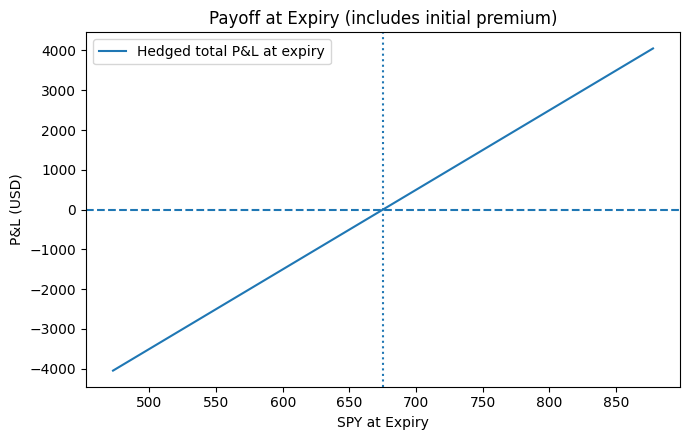

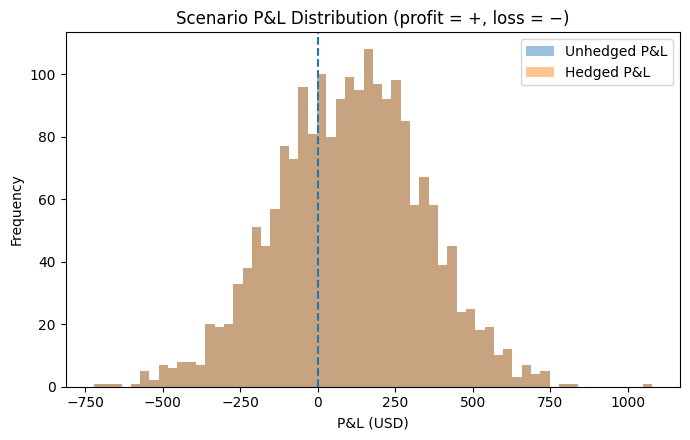

In [7]:
# ================================
# ONE-BUTTON RUNNER (Notebook/Colab)
# ================================
def run_all_once(
    quotes_df: pd.DataFrame,
    *,
    regime_mode: str = "auto",          # "auto" or "manual"
    regime_override: str | None = None, # "LOW"|"MID"|"HIGH" when manual
    horizon: str = "1w",
    n_scen: int = 2000,
    seed: int = 123,
    alpha: float = 0.95,
    n_shares: int = 20,
    risk_free: float = 0.00,
    retail_mode: bool = True,
    allow_selling: bool = False,        # ignored if retail_mode=True unless you set True explicitly
    zero_cost: bool = False,
    allow_net_credit: bool = False,     # only matters when zero_cost=False
    budget_usd: float = 200.0,          # ignored if zero_cost=True
    max_buy_contracts: float = 10.0,
    max_sell_contracts: float = 10.0,
    integer_round: bool = True,
    step: float = 1.0,                  # whole contracts
    budget_enforced_after_rounding: bool = True,
    zero_cost_tolerance: float = 5.0,
    make_plots: bool = True
):
    # 1) pick regime pool
    if regime_mode == "auto":
        chosen, pool_used = select_regime_pool(df_reg, mode="auto")
    else:
        if regime_override is None:
            raise ValueError("When regime_mode='manual', provide regime_override in {'LOW','MID','HIGH'}.")
        chosen, pool_used = select_regime_pool(df_reg, mode="manual", override=str(regime_override).upper())
    print(f"Regime selected: {chosen} | pool size: {len(pool_used)}")

    # 2) strict bid/ask validation (mid derived)
    q_local = validate_quotes_df_bidask_strict(quotes_df)

    # 3) prefs from user input
    prefs = Prefs(
        horizon=horizon, n_scen=n_scen, seed=seed, alpha=alpha,
        n_shares=n_shares, risk_free=risk_free,
        retail_mode=retail_mode,
        allow_selling=allow_selling,
        zero_cost=zero_cost, allow_net_credit=allow_net_credit, budget_usd=budget_usd,
        max_buy_contracts=max_buy_contracts, max_sell_contracts=max_sell_contracts,
        integer_round=integer_round, step=step,
        budget_enforced_after_rounding=budget_enforced_after_rounding,
        zero_cost_tolerance=zero_cost_tolerance,
        make_plots=make_plots
    )

    # 4) run workflow (LP + rounding + metrics + plots)
    out = run_hedge_workflow(q_local, df_reg, pool_used, prefs)
    return out

# ==== Example "one-button" run ====
# Replace `quotes_demo` with your table of bid/ask quotes for a *single expiry*.
out = run_all_once(
    quotes_df=quotes_demo,
    regime_mode="auto",           # or "manual"
    # regime_override="MID",      # if manual
    horizon="1w",
    n_scen=2000,
    seed=123,
    alpha=0.95,
    n_shares=20,
    retail_mode=True,             # retail
    allow_selling=False,          # buy-only
    zero_cost=False,
    budget_usd=200.0,
    integer_round=True,
    step=1.0,                     # whole contracts
    make_plots=True
)


In [8]:
%%writefile app.py
# app.py — Minimal Streamlit UI for your hedge engine
import streamlit as st
import pandas as pd

st.set_page_config(page_title="SPY Hedge Optimizer", layout="wide")
st.title("🛡️ SPY CVaR Hedge Optimizer (1-week)")

# --- Quotes input ---
st.subheader("1) Upload or Paste Quotes (single expiry)")
st.write("Required columns: kind (C/P), strike, bid, ask, expiry (YYYY-MM-DD). Optional: label")

uploaded = st.file_uploader("Upload CSV", type=["csv"])
if uploaded:
    quotes_df = pd.read_csv(uploaded)
else:
    # tiny default to demo; replace or leave empty to force upload
    quotes_df = pd.DataFrame({
        "kind":["C","C","P","P"],
        "strike":[665,673,670,677],
        "bid":[11.39,5.72,4.51,7.45],
        "ask":[11.44,5.76,4.53,7.49],
        "expiry":["2025-10-31"]*4,
        "label":["C665","C673","P670","P677"]
    })

st.dataframe(quotes_df, use_container_width=True)

# --- Regime selection ---
st.subheader("2) Regime & Scenario")
regime_mode = st.radio("Regime selection", ["auto","manual"], horizontal=True)
regime_override = None
if regime_mode == "manual":
    regime_override = st.selectbox("Choose regime", ["LOW","MID","HIGH"], index=1)

horizon = st.selectbox("Horizon", ["1w","1m","3m","1y"], index=0)
n_scen  = st.slider("Scenarios", 1000, 10000, 2000, step=500)
alpha   = st.slider("Tail level (α)", 0.80, 0.99, 0.95, step=0.01)

# --- Portfolio & permissions ---
st.subheader("3) Portfolio & Permissions")
n_shares = st.number_input("SPY shares", min_value=0, value=20, step=1)
retail_mode = st.checkbox("Retail mode (buy-only)", value=True)
allow_selling = st.checkbox("Allow selling (spreads/collars)", value=not retail_mode)
zero_cost = st.checkbox("Zero-cost (institutional)", value=False)
budget_usd = st.number_input("Premium budget (USD)", min_value=0.0, value=200.0, step=50.0)
allow_net_credit = st.checkbox("Allow net credit when not zero-cost", value=False)
max_buy = st.slider("Max buy contracts (per leg)", 0.0, 200.0, 10.0, step=1.0)
max_sell = st.slider("Max sell contracts (per leg)", 0.0, 200.0, 10.0, step=1.0)

# --- Rounding & plotting ---
st.subheader("4) Execution & Display")
integer_round = st.checkbox("Round to whole contracts", value=True)
step = st.select_slider("Rounding step", options=[1.0, 0.5, 0.1], value=1.0)
keep_budget = st.checkbox("Budget-enforced after rounding (retail)", value=True)
zc_tol = st.number_input("Zero-cost tolerance after rounding (USD)", min_value=0.0, value=5.0, step=1.0)
make_plots = st.checkbox("Show charts", value=True)

# --- Run button ---
if st.button("🚀 Simulate / Optimize"):
    try:
        # validate quotes & run
        q_local = validate_quotes_df_bidask_strict(quotes_df)
        prefs = Prefs(
            horizon=horizon, n_scen=n_scen, seed=123, alpha=alpha,
            n_shares=int(n_shares), risk_free=0.00,
            retail_mode=retail_mode, allow_selling=allow_selling,
            zero_cost=zero_cost, allow_net_credit=allow_net_credit, budget_usd=float(budget_usd),
            max_buy_contracts=float(max_buy), max_sell_contracts=float(max_sell),
            integer_round=integer_round, step=float(step),
            budget_enforced_after_rounding=keep_budget,
            zero_cost_tolerance=float(zc_tol),
            make_plots=False  # we’ll draw below with st.pyplot
        )

        # choose regime pool
        if regime_mode == "auto":
            chosen, pool_used = select_regime_pool(df_reg, mode="auto")
        else:
            chosen, pool_used = select_regime_pool(df_reg, mode="manual", override=regime_override)

        st.info(f"Regime selected: **{chosen}** | pool size: {len(pool_used)}")

        # run workflow
        out = run_hedge_workflow(q_local, df_reg, pool_used, prefs)

        # show LP and rounded portfolios
        lp = out["lp_result"]
        st.subheader("Optimal Contracts (LP fractional)")
        lp_tbl = pd.DataFrame({
            "label": lp["weights"]["labels"],
            "buy":   lp["weights"]["buy"],
            "sell":  lp["weights"]["sell"],
            "net":   lp["weights"]["net"],
        })
        st.dataframe(lp_tbl, use_container_width=True)
        st.write(f"Initial spend (LP): **${lp['spend_usd']:.2f}**")

        st.subheader("Rounded (executable) portfolio")
        r = out["rounded"]
        rd_tbl = pd.DataFrame({
            "label": lp["weights"]["labels"],
            "buy":   r["buy"],
            "sell":  r["sell"],
            "net":   r["net"],
        })
        st.dataframe(rd_tbl, use_container_width=True)
        st.write(f"Rounded initial spend: **${r['spend']:.2f}**")

        # before/after VaR & CVaR
        st.subheader("Risk (VaR/CVaR on loss)")
        def _vc(pnl, a):
            loss = -pd.Series(pnl)
            VaR = float(loss.quantile(a))
            CVaR = float(loss[loss >= VaR].mean())
            return VaR, CVaR
        vu, cu = _vc(out["pnl"]["unhedged"], alpha)
        vh, ch = _vc(out["pnl"]["hedged"],   alpha)
        metrics = pd.DataFrame({
            "": ["Unhedged","Hedged","Improvement (Δ)"],
            f"VaR@{alpha:.2f}":[vu, vh, vu-vh],
            f"CVaR@{alpha:.2f}":[cu, ch, cu-ch],
        })
        st.dataframe(metrics, use_container_width=True)

        # charts
        if make_plots:
            import matplotlib.pyplot as plt
            # payoff at expiry
            fig1 = plt.figure(figsize=(7,4.5))
            S0 = float(df_reg["SPY"].iloc[-1])
            # reuse small inline payoff from earlier (quick re-implementation)
            mult=100.0
            ask0 = q_local['ask'].to_numpy(float); bid0 = q_local['bid'].to_numpy(float)
            strikes = q_local['strike'].to_numpy(float); kinds = q_local['kind'].tolist()
            wp = r["buy"]; wm = r["sell"]
            init_cost = float((ask0*mult) @ wp + (-bid0*mult) @ wm)
            S_grid = np.linspace(0.7*S0, 1.3*S0, 161)
            def intrinsic(S,K,kind): return max(S-K,0.0) if kind=='C' else max(K-S,0.0)
            opt_payoff = []
            for S in S_grid:
                v=0.0
                for j,k in enumerate(kinds):
                    intr = intrinsic(S, strikes[j], k)*mult
                    v += wp[j]*intr - wm[j]*intr
                opt_payoff.append(v)
            shares = prefs.n_shares*(S_grid - S0)
            tot = shares + pd.Series(opt_payoff).values - init_cost
            plt.plot(S_grid, tot, label="Hedged total P&L at expiry")
            plt.axhline(0, ls="--"); plt.axvline(S0, ls=":")
            plt.title("Payoff at Expiry (includes initial premium)")
            plt.xlabel("SPY at Expiry"); plt.ylabel("P&L (USD)"); plt.legend(); st.pyplot(fig1)

            # P&L histogram
            fig2 = plt.figure(figsize=(7,4.5))
            plt.hist(out["pnl"]["unhedged"], bins=60, alpha=0.45, label="Unhedged P&L")
            plt.hist(out["pnl"]["hedged"],   bins=60, alpha=0.45, label="Hedged P&L")
            plt.axvline(0, ls="--")
            plt.title("Scenario P&L Distribution (profit = +, loss = −)")
            plt.xlabel("P&L (USD)"); plt.ylabel("Frequency"); plt.legend()
            st.pyplot(fig2)

    except Exception as e:
        st.error(f"Error: {e}")


Writing app.py


In [9]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.8 MB/s eta 0:00:00


In [ ]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

2025-11-06 01:03:26.482 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-11-06 01:04:15.813 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-11-06 01:04:18.644 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-11-06 01:04:35.755 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretc

In [14]:
# Install ngrok
!pip install pyngrok

# Get your auth token from the Colab secrets manager
from google.colab import userdata
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

# Authenticate ngrok
!ngrok authtoken {NGROK_AUTH_TOKEN}

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [15]:
# Run ngrok to tunnel the Streamlit port
from pyngrok import ngrok

# Terminate any existing ngrok tunnels
ngrok.kill()

# Open a tunnel to the Streamlit port (8501)
public_url = ngrok.connect(8501).public_url
print(f"Streamlit app is accessible at: {public_url}")

Streamlit app is accessible at: https://4559d87c0b8c.ngrok-free.app
